In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.interpolate import interp1d
from functools import cache
from IPython import display

import matplotlib

%matplotlib inline

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (14,9)
matplotlib.rcParams['savefig.bbox'] = 'tight'

import multi_distr
from wish_distr import e5s_pdf, e4s_pdf, w5s_pdf, w4s_pdf
import markov

## Code for accessing distributions.
All the distributions in the writeup can be accessed through these functions in one way or another.

In [2]:
e5s_mult = multi_distr.MultiDistr(e5s_pdf, n_max=90)
e4s_mult = multi_distr.MultiDistr(e4s_pdf, n_max=10)
w5s_mult = multi_distr.MultiDistr(w5s_pdf, n_max=80)
w4s_mult = multi_distr.MultiDistr(w4s_pdf, n_max=10)

e5s_mkv = [[0,0,0],[1/2,0,0],[1/2,1,1]]
e4s_mkv = [[1/3,2/3,0],[1/2,0,0],[1/6,1/3,1]]
w5s_mkv = [[3/8,1/2,0],[1/4,0,0],[3/8,1/2,1]]
w4s_mkv = [[3/5,4/5,0],[1/4,0,0],[3/20,1/5,1]]

We can call the functions fairly simply as below. The functions are vectorized, so you can pass ranges in as well.

In [3]:
# Prob roll 5* on 15th wish
print(f'P(X=15): {e5s_pdf(15)}')

# Prob we roll 4th 5* on 200th wish
print(f'P(X4=200): {e5s_mult(200, 4)}')

# Prob we roll 3rd 5* between 160 and 200 wishes
print(f'P(160 <= X3 <= 200): {np.sum( e5s_mult(np.arange(160, 200), 3) )}')

P(X=15): 0.005515191947205601
P(X4=200): 0.00411759058943906
P(160 <= X3 <= 200): 0.3323604046008147


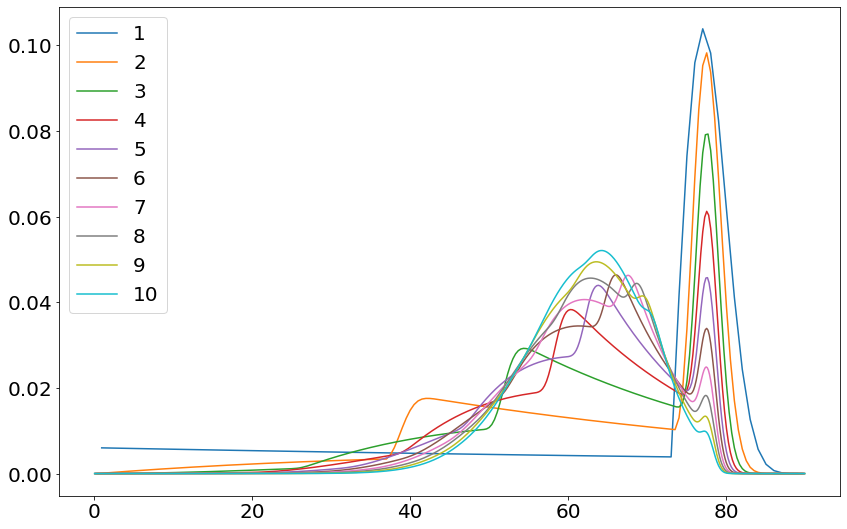

In [4]:
# Showing normalized wish distributions for 1-10 5* hits on event banner
to_show = [1,2,3,4,5,6,7, 8,9,10]
for i in to_show:
    x = np.arange(1, i * 90)
    plt.plot(x / i, i*e5s_mult(x, i))
plt.legend(to_show)

#### Targeting multiple of one 4* or 5*
We need to treat event 5-star different from event 4-star or weapon 4/5-star because the markov chain is degenerate.

In [5]:
hitter = markov.distr_hitter(markov.MarkovSolver(e5s_mkv), e5s_mult)
e5s_targ_mult = multi_distr.MultiDistr(hitter, 180)

# Rolling for an event 5* with 4*60=240 wishes.
print(f'Prob C0: {np.sum(e5s_targ_mult(np.arange(4*60), 1))}')
print(f'Prob C1: {np.sum(e5s_targ_mult(np.arange(4*60), 2))}')
print(f'Prob C2: {np.sum(e5s_targ_mult(np.arange(4*60), 3))}')
print(f'Prob C3: {np.sum(e5s_targ_mult(np.arange(4*60), 4))}')

PATHOLOGICAL MARKOV CHAIN
Prob C0: 0.9999999999999998
Prob C1: 0.8351592774470724
Prob C2: 0.30606559176905984
Prob C3: 0.0582507756737439


Targeting copies of Event 4-star. The runtime drastically increases because we no longer have any guarantee to halt (get our desired 4-star) after enough wishes. We need to use a different solver routine to get the numbers we want now. (DupeTargMulti)

In [33]:
infinity = 500
e4s_targ_mult = multi_distr.DupeTargMulti(markov.MarkovSolver(e4s_mkv), e4s_mult, infinity)

# Rolling for C2 on some 4-star character. Let's say we've saved 60 wishes.
print(f'Prob C2 or higher: {np.sum(e4s_targ_mult(np.arange(66), 3))}')

# Envi's Rosaria luck, just cuz I know you want it. Unlucky, but very believably so.
print(f'Prob. no Rosaria: {1 - np.sum(e4s_targ_mult(np.arange(66), 1))}')

Prob C2 or higher: 0.2466261359686272
Prob. no Rosaria: 0.12855938544977596


/Users/albertxu/.pyenv/versions/3.9.0/envs/mpl/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


We can actually calculate the distribution of constellation levels (num. dupes) after 65 wishes.

<BarContainer object of 8 artists>

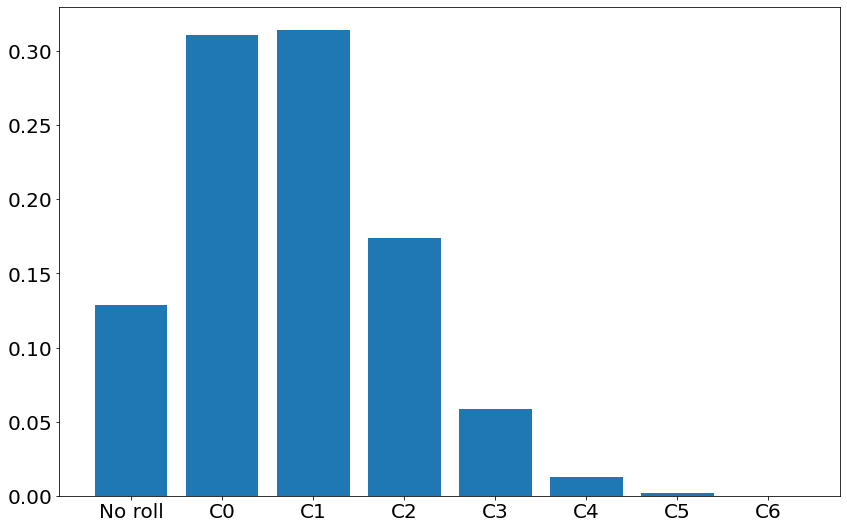

In [41]:
const_distr = np.array([np.sum(e4s_targ_mult(np.arange(66), i, force_exact=True)) for i in [0,1,2,3,4,5,6,7]])
m_dist = np.append(const_distr[:-1] - const_distr[1:], const_distr[-1])
plt.bar([0,1,2,3,4,5,6,7], m_dist, tick_label=['No roll', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'])

## Collected Data
[paimon.moe](https://paimon.moe/wish/tally) data below, to verify yourself if you so please.

In [7]:
# https://paimon.moe/wish/tally/300013
e5s_data = [242,225,219,240,211,216,209,222,214,255,225,195,210,203,225,194,190,226,196,198,225,169,199,192,194,191,185,187,172,170,174,180,202,184,168,205,176,160,183,157,187,161,166,144,198,167,196,171,169,156,161,171,162,141,176,151,152,171,175,165,127,147,155,149,165,122,132,143,153,155,124,152,127,1433,2589,3362,3525,3361,2840,2063,1433,807,397,194,79,23,9,2,2,2]
e4s_data = [14125,13307,12645,12146,11292,10680,10148,9661,98814,76151]

# https://paimon.moe/wish/tally/400012/
w5s_data = [59,85,71,86,107,101,83,65,71,65,64,78,73,66,93,62,70,53,65,65,68,69,68,69,56,57,81,52,68,48,63,48,57,53,49,44,54,39,47,50,49,56,66,52,54,48,48,64,47,50,37,34,43,61,77,47,51,50,50,40,50,39,406,686,840,804,790,587,386,215,107,59,13,3,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0]
w4s_data = [4238,4048,3908,3623,3307,3248,3015,29881,15173,176]

# supplement https://paimon.moe/wish/tally/400008/
w5sv2 = [144,124,134,131,126,132,143,144,123,130,140,125,117,115,112,110,123,120,114,112,92,106,113,82,83,93,93,110,93,93,79,84,95,88,78,81,94,68,75,73,95,79,68,90,72,75,73,73,61,83,64,64,70,87,85,94,87,80,71,63,61,90,622,1169,1370,1369,1270,896,545,308,179,62,28,4,4,2,2,1,1,1,0,1,1,2,0,0,1,0,0,0]
w5s_data = np.array(w5s_data) + np.array(w5sv2)

In [8]:
def phi(data, return_stdevs=False):
    N = np.sum(data)
    bottom = N - np.cumsum(data)
    
    ret = data / (data + bottom)
    if return_stdevs:
        sdata = np.sqrt(data * (N - data) / N)
        sbot = np.sqrt(bottom * (N - bottom) / N)
        
        s1 =  ( 1/(data + bottom) - (ret / (data + bottom)) ) * sdata
        s2 = (ret / (data + bottom)) * sbot
        return ret, np.sqrt(s1*s1 + s2*s2)
    return ret

cd = np.cumsum([e5s_pdf(i) for i in range(91)])
def sim_e5s_pt():
    return np.argmax(np.random.random() < cd)

def sim_e5s_data():
    to_rm = np.zeros(91)
    reset = np.zeros(91)
    while True:
        i = sim_e5s_pt()

        if to_rm[i] + 1 > w5s_data[i - 1]:
            to_rm = reset.copy()
            display.clear_output(wait=True)
            display.display(f'resetting on {i}')
            continue

        to_rm[i] += 1
        if np.sum(to_rm[81:]) >= np.sum(w5s_data[80:]):
            break
        if i >= 81:
            display.display(f'added new reset checkpoint! {i}')
            reset = to_rm.copy()
    return to_rm

# to_rm = sim_e5s_data()[1:]
to_rm = [1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,2,
         0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,
         0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,2,1,0,0,
         0,0,1,0,1,0,0,0,0,0,0,0,0,2,0,3,3,1,1,1,
         0,1,2,2,0,0,1,0,0,0]

fixed = w5s_data - to_rm

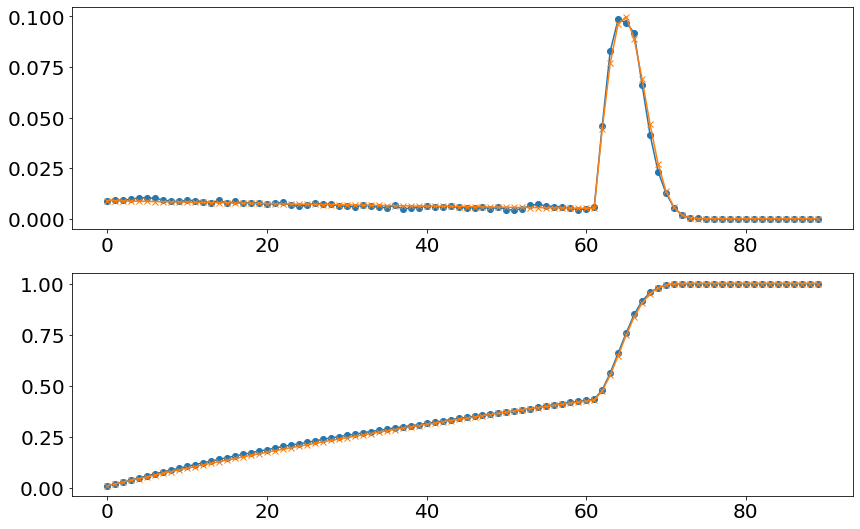

In [9]:
x = np.arange(1, 91)

plt.subplot(211)
plt.plot(fixed / np.sum(fixed), marker='o')
plt.plot(w5s_mult(np.arange(1, 91), 1), marker='x')
plt.subplot(212)
plt.plot(np.cumsum(fixed / np.sum(fixed)), marker='o')
plt.plot(np.cumsum(w5s_mult(np.arange(1, 91), 1)), marker='x')
